# Signal Processing & Temporal Structure (Sprint 2)

In this notebook, we transform raw Sleep-EDF EEG recordings into
cleaned, temporally structured representations suitable for
sleep analysis and downstream insight generation.

This step moves beyond data loading toward **physiologically meaningful
signal processing**, a core requirement for computational neuroscience
and clinical sleep research.

Sprint 2 focuses on:
- EEG preprocessing
- Epoch-level spectral features
- Temporal smoothing of sleep stages
- Sleep cycle detection


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import sys
from pathlib import Path
PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))

from src.io.load_edf import load_edf
from src.preprocessing.eeg_preprocess import preprocess_eeg
from src.preprocessing.epoching import extract_stage_labels, epoch_signal # epoch_eeg_with_stages
from src.features.spectral_features import compute_bandpower
from src.postprocessing.hypnogram_smoothing import smooth_hypnogram
from src.analysis.sleep_cycles import detect_sleep_cycles

## 1. Load Raw EEG and Hypnogram Annotations

We begin by loading:
- Polysomnography (PSG) EEG recordings
- Expert-labeled hypnogram annotations

These annotations serve as the ground truth sleep-stage labels.


In [2]:
psg_path = str(PROJECT_ROOT)+"/data/raw_sleep_edf/SC4002E0-PSG.edf"
hyp_path = str(PROJECT_ROOT)+"/data/raw_sleep_edf/SC4002EC-Hypnogram.edf"
raw = load_edf(psg_path, hyp_path)

/Users/onogantsog/Code/stageclassification/src/io/load_edf.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/Users/onogantsog/Code/stageclassification/src/io/load_edf.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/Users/onogantsog/Code/stageclassification/src/io/load_edf.py:6: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/Users/onogantsog/Code/stageclassification/src/io/load_edf.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot)


## 2. Raw EEG Inspection

Before any preprocessing, we inspect the raw EEG signal
to understand baseline noise levels and signal quality.


Using matplotlib as 2D backend.


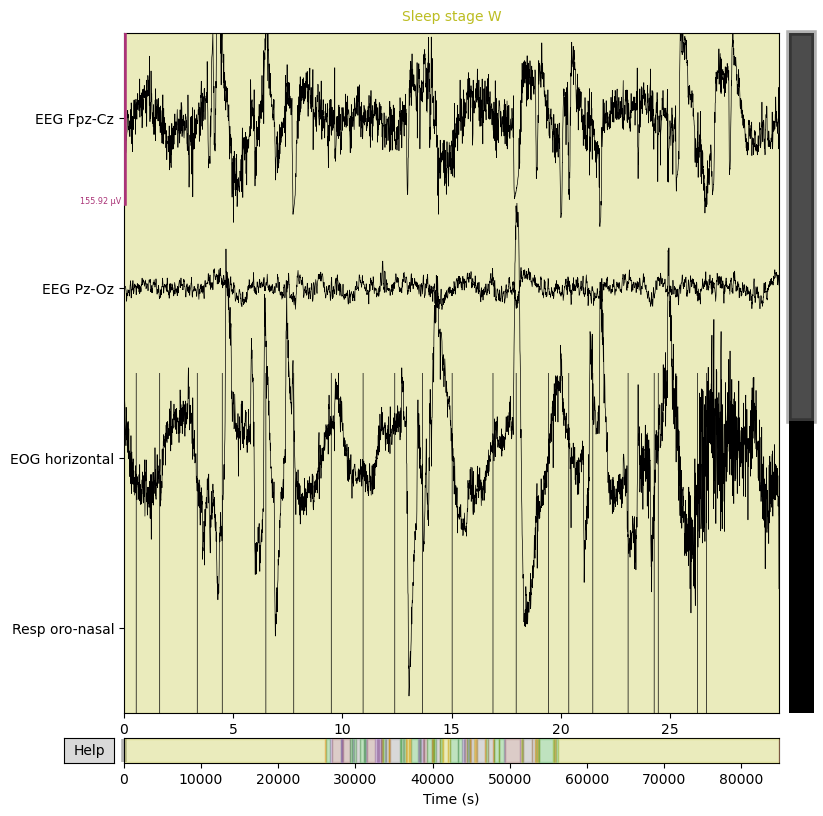

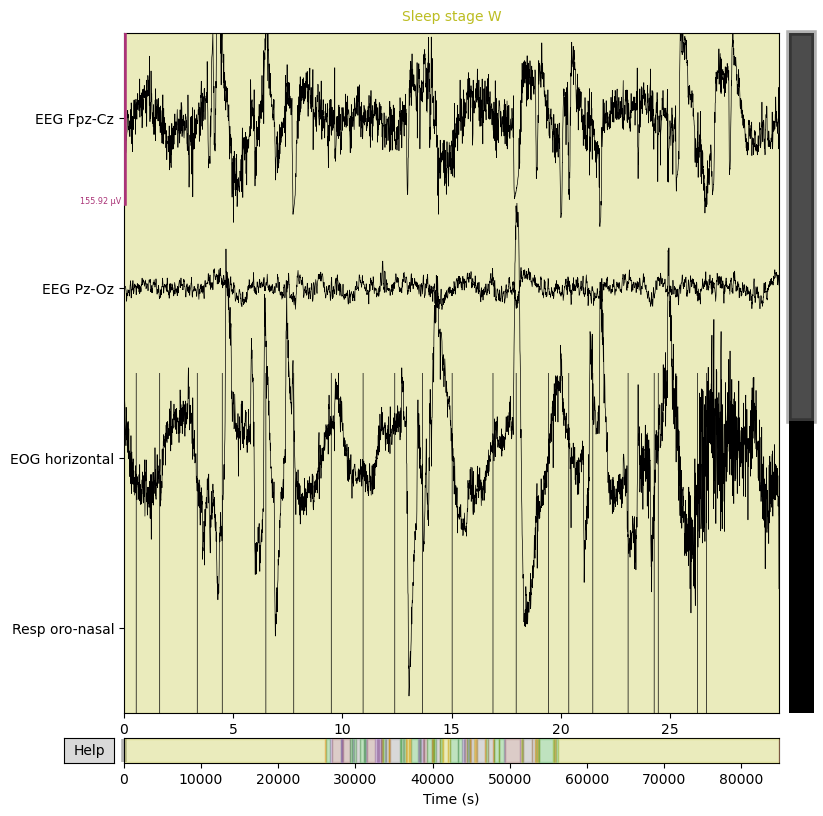

In [3]:
raw.plot(duration=30, n_channels=4, scalings="auto")

## 3. EEG Preprocessing Pipeline

We apply a conservative, explainable preprocessing pipeline:

- EEG channel selection
- Band-pass filtering (0.3–35 Hz)
- Line-noise removal
- Resampling to 100 Hz
- Simple amplitude-based artifact rejection

This approach prioritizes interpretability over aggressive denoising.

In [4]:
raw_clean = preprocess_eeg(raw)

after reject artifact: nan_frac=0.143359, std=nan, min=nan, max=nan


## 4. Epoching and Stage Alignment

Sleep EEG is analyzed in fixed-length epochs (30 seconds),
aligned with hypnogram labels.

This produces:
- Epoch-wise EEG data
- Corresponding sleep stage labels

In [5]:
X_epochs = epoch_signal(raw)
y_stages = extract_stage_labels(raw)

print("Epochs shape:", X_epochs.shape)
print("Unique stages:", np.unique(y_stages))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Epochs shape: (2830, 3000)
Unique stages: [0 1 2 3 4]


In [6]:
epoch_stds = np.std(X_epochs, axis=1)

print("Median std:", np.median(epoch_stds))
print("Min std:", np.min(epoch_stds))
print("Max std:", np.max(epoch_stds))

print("Non-zero epochs:", np.sum(epoch_stds > 1e-6))
print("Total epochs:", len(epoch_stds))


Median std: 2.8027452035766282e-05
Min std: 8.26098279141585e-06
Max std: 5.652392683563455e-05
Non-zero epochs: 2830
Total epochs: 2830


## 5. Spectral Feature Extraction

We compute canonical EEG band power for each epoch:
- Delta (0.5–4 Hz)
- Theta (4–8 Hz)
- Alpha (8–12 Hz)
- Sigma (12–15 Hz)
- Beta (15–30 Hz)

These features summarize physiologically meaningful sleep dynamics.

In [7]:
bandpower = compute_bandpower(
    X_epochs,
    sfreq=raw_clean.info["sfreq"]
)

bandpower.keys()

Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective wind

dict_keys(['delta', 'theta', 'alpha', 'sigma', 'beta'])

In [8]:
np.mean(np.isnan(bandpower["beta"]))

np.float64(0.0)

### Example: Delta Power Across the Night

Delta power reflects slow-wave sleep intensity
and is highest during early-night NREM sleep.

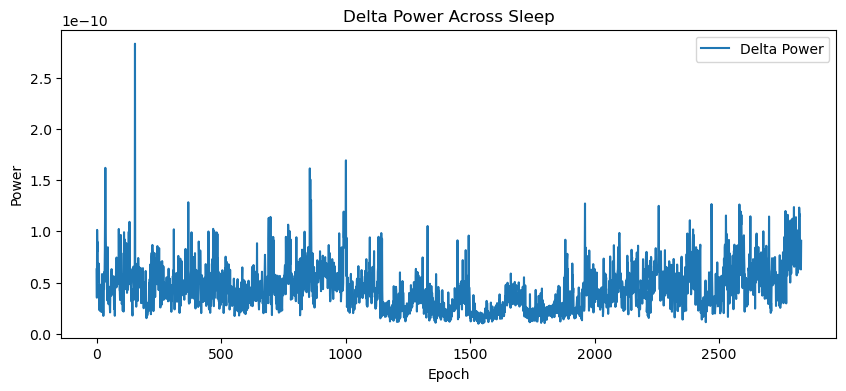

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(bandpower["theta"], label="Delta Power")
plt.xlabel("Epoch")
plt.ylabel("Power")
plt.title("Delta Power Across Sleep")
plt.legend()
plt.show()

## 6. Hypnogram Smoothing

Raw sleep-stage annotations often contain spurious transitions.
We apply temporal smoothing to enforce physiological consistency.

This improves interpretability and downstream cycle detection.

In [ ]:
y_smooth

In [10]:
y_smooth = smooth_hypnogram(
    y_stages,
    method="majority",
    window_size=5
)

smooth_hypnogram

<function src.postprocessing.hypnogram_smoothing.smooth_hypnogram(hypnogram: numpy.ndarray, method: str = 'combined', **kwargs) -> numpy.ndarray>

### Raw vs Smoothed Sleep Stages

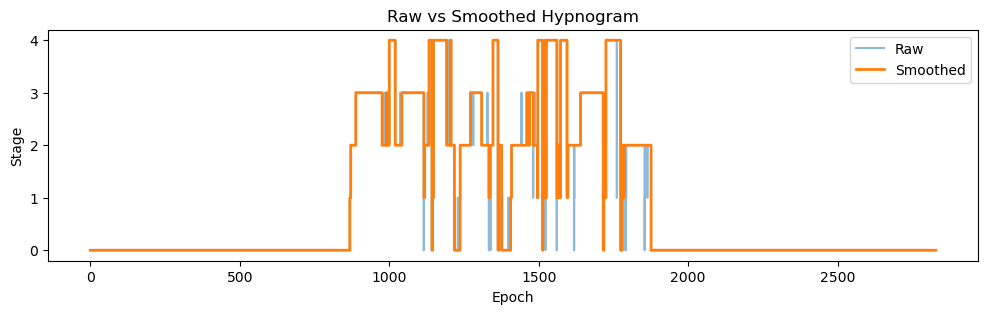

In [11]:
plt.figure(figsize=(12, 3))
plt.step(range(len(y_stages)), y_stages, label="Raw", alpha=0.5)
plt.step(range(len(y_smooth)), y_smooth, label="Smoothed", linewidth=2)
plt.yticks(sorted(set(y_stages)))
plt.xlabel("Epoch")
plt.ylabel("Stage")
plt.legend()
plt.title("Raw vs Smoothed Hypnogram")
plt.show()

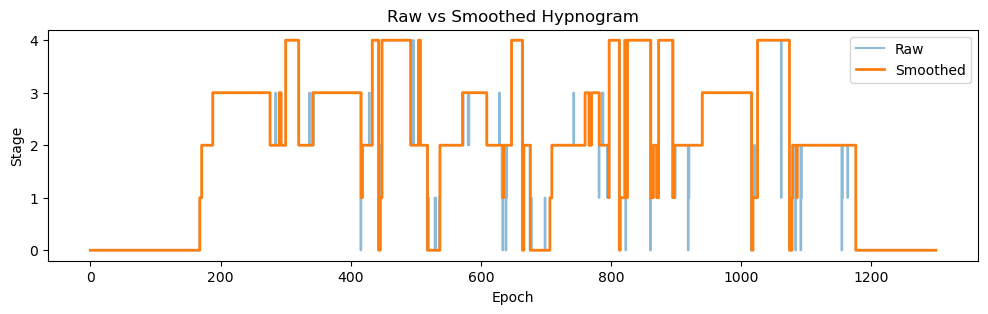

In [17]:
plt.figure(figsize=(12, 3))
plt.step(range(1300), y_stages[700:2000], label="Raw", alpha=0.5)
plt.step(range(1300), y_smooth[700:2000], label="Smoothed", linewidth=2)
plt.yticks(sorted(set(y_stages)))
plt.xlabel("Epoch")
plt.ylabel("Stage")
plt.legend()
plt.title("Raw vs Smoothed Hypnogram")
plt.show()

## 7. Sleep Cycle Detection

Sleep unfolds in structured NREM–REM cycles.
We detect cycles to enable higher-level sleep architecture analysis.

In [18]:
cycles = detect_sleep_cycles(y_smooth)

cycles

[]

### Sleep Cycles Overlay

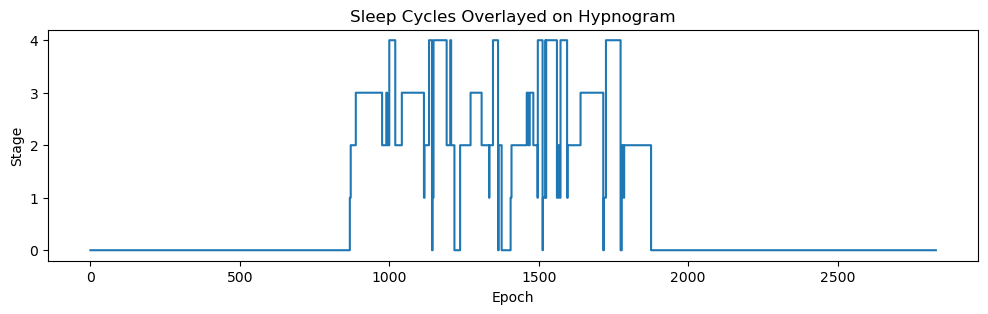

In [13]:
plt.figure(figsize=(12, 3))
plt.step(range(len(y_smooth)), y_smooth, label="Stage")

for cycle in cycles:
    plt.axvspan(cycle["start"], cycle["end"], alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Stage")
plt.title("Sleep Cycles Overlayed on Hypnogram")
plt.show()

## Sprint 2 Summary

In this notebook, we demonstrated:
- EEG signal preprocessing grounded in physiology
- Epoch-level spectral feature extraction
- Temporal smoothing of sleep stages
- Structured sleep cycle detection

These steps transform raw polysomnography data into
interpretable representations of brain-state dynamics,
enabling higher-level sleep insights in subsequent sprints.